Test is a test notebook where I develop the GOR3 algorithm.

Things to do:

- The first thing we should do is import the data and clean the data to make it ready for use. 
- Understand the GOR 3 Algorithm
- Understand how we should deal with edges 
- Understand what we need to do with invalid entries and how we deal with it in algorithm
- Understand how we should make it optimised leave-one-out. (don't recount everything with every new protein sequence).
- How to summarise the results of the GOR3 (per data set)
- How to summarise the results per protein family.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [202]:
# Algorithm to evaluate a protein. 
# Create a random protein sequence. Where the amino acids are code between 0,20
Proteins = np.random.randint(3,size=100)
SeqLen = len(Proteins)

In [203]:
# Add some invalid entries and pad the sides with -1's which represent the edges.
Proteins[[15,74,87]] = -1 
#Proteins = np.concatenate((-np.ones(8),Proteins,-np.ones(8))).astype(int)

In [188]:
# Create for now a dummy frequency tensor:
freq = np.ones(shape=(3,17,3,3),dtype=float)
freq[0,8,0,0] = 7
freq[0,8,1,1] = 10
freq[0,8,2,2] = 13
freq[1,8,0,0] = 70
freq[1,8,1,1] = 100
freq[1,8,2,2] = 130


CountSSperR = np.ones(shape=(3,20))
CountSS = np.sum(CountSSperR,-1)
otherSS = np.array([[1,2],[0,2],[0,1]]) # Have the index of the other Secundary Structure such that we can sum of the other SS
logDiff = np.log(CountSS/np.sum(CountSS[otherSS],axis=-1))
logDiffRj = np.log(CountSSperR/np.sum(CountSSperR[otherSS],axis=-2)) # -2 since -1 are the amino acids

In [208]:
Proteins

array([ 1,  2,  0,  2,  2,  1,  0,  2,  2,  0,  1,  1,  0,  2,  1, -1,  2,
        0,  1,  0,  2,  2,  0,  1,  0,  2,  1,  2,  1,  1,  2,  0,  0,  1,
        1,  1,  2,  2,  1,  1,  2,  2,  1,  0,  1,  2,  1,  1,  1,  0,  1,
        2,  0,  2,  0,  2,  2,  2,  0,  1,  1,  0,  2,  1,  0,  2,  0,  1,
        1,  0,  2,  1,  2,  2, -1,  1,  2,  1,  1,  2,  2,  1,  1,  1,  2,
        1,  2, -1,  1,  1,  2,  1,  2,  0,  0,  0,  2,  1,  0,  0])

In [190]:
CountSS

array([20., 20., 20.])

In [169]:
valid = np.array([0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]).astype(bool)
seq = np.arange(17)
vseq = seq[valid]
mCorrect = np.where(valid)[0]
freq[0,mCorrect,vseq,0]

IndexError: index 8 is out of bounds for axis 2 with size 3

In [196]:
testarray = np.array([4,8,7])
if 8 in testarray:
    print("Yes")

Yes


In [220]:
import time
startTime = time.time()
for i in range(500):
    out = predictSS(Proteins,freq,logDiff,logDiffRj)
Diff = time.time() - startTime
print(f"{np.round(Diff,2)} seconds")

45.34 seconds


In [2]:
def predictSS(protSequence, freq, logDiff, logDiffRj, SStrue, predictInvalidResidue=False):
    """
    Input:
        - protSequence : 1D-numpy array, Represents the proteins sequence, where the aminoacids are labeled as integers from 0 to 19
        - freq : 4D-numpy array shape = (3,17,20,20) representing the frequency count of the data set.
            - axis0 = Secundary structure
            - axis1 = relative position m from the window center positioned at j in the protein sequence
            - axis2 = amino Acid at the position m. = R_{j+m}
            - axis3 = amino Acid at the centre. = R_j
        - logDiff: 1D-numpy array of length 3. This is the logarithm of the relative SS structure count: log(f_s/f_{not_s})
        - logDiffRj: 2D-numpy array of shape (3,20). This is the logarithm of the relative SS structure count per amino accid: log(f_{s,R}/f_{not_s,R})
        - SStrue
        - dealWithInvalidResidue
    Output:
        - SS_result: 1D-numpy array with the predicted SS of the protein sequence
        - ISS: 2D-numpy array with the information per SS per amino accid in the protein sequence.
        
    """
    # Add 8 "-1"'s at the beginning and end of the protein sequence. 
    # This is done such that we can have running window of lenght 8 at each side at the edges of the protein sequences. 
    # Use -1 since we offcourse vieuw these as invalid entries.
    paddedSequence = np.concatenate((-np.ones(8),protSequence,-np.ones(8))).astype(int)
    SeqLen = len(protSequence)
    otherSS = np.array([[1,2],[0,2],[0,1]]) # Have the index of the other Secundary Structure such that we can sum of the other SS
    
    # Construct the output value ISS
    ISS = -np.ones(shape=(3,SeqLen)) # use -1 to later on detect invalid entries in the protein sequence.
    
    for j, r_j in enumerate(paddedSequence):
        if j-8 > SeqLen: # We have reached the end.
            break
        if r_j<0: # We skip over invalid entries. (These are the padded edges and invalid entries)
            continue
        # r_j is valid so set the ISS level equalt to zero. Unvalid r_j are kept -1
        ISS[:,j-8] = np.zeros(3)             
        for SS in range(3):
            for m, r_jm in enumerate(paddedSequence[j-8:j+9]): # m in [0,16],
                if r_jm<0:
                    continue
                # Compute the logSum
                ISS[SS,j-8] += np.log(freq[SS,m,r_jm,r_j]/np.sum(freq[otherSS[SS],m,r_jm,r_j]))
                if m==8: 
                    ISS[SS,j-8] += logDiff[SS]
                else:
                    ISS[SS,j-8] += logDiffRj[SS,r_j]

    SS_result = np.argmax(ISS,axis=0)
    
    if not predictInvalidResidue:
        SS_result[protSequence<0] = -1 # Let the invalid protein sequences stay flagged as invalid.
        return SS_result, ISS

    ###################################################
    ##### Deal with invalid amino acid entries ######
    ##################################################
    # This is not general yet !. 
    
    InvalidResidue = np.logical_and(protSequence<0 and trueSS>=0) # Make sure that invalid entry is not duo a skip. 
    for index in InvalidResidue:
        if index == 0: # The invalid is the first element
            indexToCopy = 1
            indexIsNotValid = np.any(Invalidindex==indexToCopy)
            while indexIsNotValid: # Keep searching until we are sure that the next index is also not an invalid one. 
                indexToCopy+=1
                nextIsValid = np.any(InvalidIndex==indexToCopy) and trueSS[indexToCopy]>=0
            SS_result[index] = SS_result[indexToCopy] # Set it equal to the first valid element. 
        else: # In all other cases we pick the one below
            SS_result[index] = SS_result[index-1]
        # The reason why we pick the one is clarified by the logic that we would have else used:

#       elif (index-1)==SeqLen # The invalid index is the last element
#           SS_result[index] = SS_result[index-1] # Set equal to the element before.
#       elif SS_result[index-1]==SS_result[index+1] # SS around in valid point is the same
#           SS_result[index] = SS_result[index-1]
#       else: # By default just pick the one below, this way we are sure the entry exist. 
#           SS_result[index]=SS_result[index-1] 

        # And so in all other cases it would have been pick the one below so. We can just simplify it with an easy else. 

    return SS_result, ISS # Return the found SS and the information values.

------
Left to do now is reading in the data file and computing the frequency tables.

In [3]:
def freqTableOfProtein(protSequence,SS):
    """
    Input:
        - protSequence : 1D-numpy array, Represents the proteins sequence, where the aminoacids are labeled as integers from 0 to 19
        - SS : 1D-numpy array holding the know secundary structure of the 
    Output:
    - freq : 4D-numpy array shape = (3,17,20,20) representing the frequency count of the protein sequence.
            - axis0 = Secundary structure
            - axis1 = relative position m from the window center positioned at j in the protein sequence
            - axis2 = amino Acid at the position m. = R_{j+m}
            - axis3 = amino Acid at the centre. = R_j
    - countSS : returns the total counts of each type of secundary structure in the sequence
    - coutSSperR: return the count of each type of secundary structure per amino acid.
    """
    freqTable = np.zeros(shape=(3,17,20,20))
    
    # Pad the sequence with 8 -1's before and after such that we can easily perform move a window around. 
    paddedSequence = np.concatenate((-np.ones(8),protSequence,-np.ones(8))).astype(int)
    paddedSS = np.concatenate((-np.ones(8),SS,-np.ones(8))).astype(int)
    
    seqLen = len(protSequence)
    
    
    #Fill freqTable
    for j, (r_j, S_j) in enumerate(zip(paddedSequence,paddedSS)):      
        if (j-8) > seqLen: # We have reached the end.
            #print(f"ends at  j= {j}")
            break    
        if r_j<0: # We skip over invalid entries. (These are the padded edges and invalid entries)
            #print(f"j={j}, r_j={r_j}")
            continue
        #print(f"j={j}, r_j={r_j}")
        for m in np.arange(-8,9):#  m=[-8,...,8]
            r_jm = paddedSequence[j+m]
            #print(f"j={j}, r_j={r_j}, m={m}, r_jm = {r_jm}")
            if r_jm<0:
                continue
            #print(f"j={j}, r_j={r_j}, m={m}, r_jm = {r_jm} AFTER")
            freqTable[S_j,m+8,r_jm,r_j]+=1
            
    middleTable = freqTable[:,8] # take all the freq counts on m=0. 
    countSSperR = np.copy(middleTable.diagonal(axis1=-1,axis2=-2)) # Extract the diagonal
    countSS = np.copy(np.sum(countSSperR,axis=-1))
    
    return freqTable, countSS, countSSperR

In [15]:
def leaveOneOutAnalysis(dataSet = "dssp", protFamily = None, predictInvalidResidue = False ):
    """
        Estimate the Q3 and CVV of the GOR method for a specific dataset using a crossvalidation of leave-one-out
    """
    totalFreqTable = np.zeros(shape=(3,17,20,20))
    totalCountSS = np.zeros(3)
    totalCountSSperR = np.zeros(shape=(3,20))
    otherSS = np.array([[1,2],[0,2],[0,1]]) # Have the index of the other Secundary Structure such that we can sum of the other SS
    
    proteinDictionary = createDataset(dataSet = dataSet, protFamily = protFamily)
    
    #First compute the full freqTable
    for key, (proteinSequence, trueSS) in proteinDictionary.items():
        freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
        totalFreqTable += freqTableFromProt
        totalCountSS += countSSFromProt
        totalCountSSperR += countSSperRFromProt
        
    
    numberProteins = len(proteinDictionary)
    
    Q3 = np.zeros(shape=(numberProteins,3))
    CVV = np.zeros(shape=(numberProteins,3))
    
    # Now do the leave-one-out:
    for i, (key,(proteinSequence, trueSS)) in enumerate(proteinDictionary.items()):
        if i%50==0:
            print(f"i={i}/{numberProteins}")
        # Remove the frequency counts of this protein.
        freqTableFromProt, countSSFromProt, countSSperRFromProt = freqTableOfProtein(proteinSequence, trueSS)
        tempFreqTable = totalFreqTable - freqTableFromProt
        tempCountSS = totalCountSS - countSSFromProt
        tempCountSSperR = totalCountSSperR - countSSperRFromProt
        
        templogDiff = np.log(np.sum(tempCountSS[otherSS],axis=-1)/tempCountSS)
        templogDiffRj = np.log(np.sum(tempCountSSperR[otherSS],axis=-2)/tempCountSSperR) # -2 since -1 are the amino acids
        
        # Set Frequency that are equal to zero = 0.00001 inorder to avoid infinities.
        tempFreqTable[tempFreqTable == 0] = 0.00001
        
        # Perform the GOR3 prediction.
        SS_result, _ = predictSS(proteinSequence, tempFreqTable, templogDiff, templogDiffRj, trueSS, predictInvalidResidue)
        
        # Remove the dummy entrances, such that they not influence the Q3 and CVV calculations
        # predictInvalidResidue = True, then invalid residue have also tried to be predicted. 
        # If we then now also remove them with the following code.
        validEntries = SS_result>=0
        ValidSS_result = SS_result[validEntries]
        ValidtrueSS = trueSS[validEntries]
            
        Q3[i] = proteinQ3(ValidSS_result, ValidtrueSS)
        CVV[i] = proteinCVV(ValidSS_result, ValidtrueSS)
    
    return Q3, CVV

In [5]:
def proteinQ3(predictedSS, trueSS):
    Q3 = np.zeros(3)
    numberHelix = np.sum(trueSS == 0)
    numberSheet = np.sum(trueSS == 1)
    numberCoil = np.sum(trueSS == 2)
    TPHelix = np.sum(np.logical_and(predictedSS==0, trueSS==0)) #Only look where trueSS = Helix, see if they are then equal.
    TPSheet = np.sum(np.logical_and(predictedSS==1, trueSS==1))
    TPCoil =  np.sum(np.logical_and(predictedSS==2, trueSS==2))
    # Return nan such that we can later filter it out.
    Q3[0] = np.nan if numberHelix==0 else TPHelix/numberHelix
    Q3[1] = np.nan if numberSheet==0 else TPSheet/numberSheet
    Q3[2] = np.nan if numberCoil==0 else TPCoil/numberCoil
    return Q3
    

def computeCVV(TP,TN,FP,FN):
    numerator = TP*TN-FP*FN
    denominator = np.sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN))
    return numerator/denominator

def proteinCVV(predictedSS, trueSS):
    numberHelix = np.sum(trueSS == 0)
    numberSheet = np.sum(trueSS == 1)
    numberCoil = np.sum(trueSS == 2)
    #Helix
    TPHelix = np.sum(np.logical_and(predictedSS==0, trueSS==0))
    TNHelix = np.sum(np.logical_and(predictedSS!=0, trueSS!=0))
    FPHelix = np.sum(np.logical_and(predictedSS==0, trueSS!=0))
    FNHelix = np.sum(np.logical_and(predictedSS!=0, trueSS==0))
    CVVHelix = np.nan if numberHelix==0 else computeCVV(TPHelix,TNHelix,FPHelix,FNHelix)
    #Sheet
    TPSheet = np.sum(np.logical_and(predictedSS==1, trueSS==1))
    TNSheet = np.sum(np.logical_and(predictedSS!=1, trueSS!=1))
    FPSheet = np.sum(np.logical_and(predictedSS==1, trueSS!=1))
    FNSheet = np.sum(np.logical_and(predictedSS!=1, trueSS==1))
    CVVSheet = np.nan if numberSheet==0 else computeCVV(TPSheet,TNSheet,FPSheet,FNSheet)
    #Coil
    TPCoil = np.sum(np.logical_and(predictedSS==2, trueSS==2))
    TNCoil = np.sum(np.logical_and(predictedSS!=2, trueSS!=2))
    FPCoil = np.sum(np.logical_and(predictedSS==2, trueSS!=2))
    FNCoil = np.sum(np.logical_and(predictedSS!=2, trueSS==2))
    CVVCoil = np.nan if numberCoil==0 else computeCVV(TPCoil,TNCoil,FPCoil,FNCoil)
    return np.array([CVVHelix, CVVSheet, CVVCoil])

-------
So we have constructed all the relevant funtions. 
It is now time to extract the data from the input files and store them appropiately. 

In [6]:
# Define some dictionary maps.
aminoToNumber = {"ALA":0, "ARG":1, "ASN":2, "ASP":3, "CYS":4, "GLN":5, "GLU":6, "GLY":7, "HIS":8, "ILE":9, "LEU":10, "LYS":11, "MET":12, "PHE":13, "PRO":14, "SER":15, "THR":16, "TRP":17, "TYR":18, "VAL":19}
shortAminoToNumber = {"A":0, "R":1, "N":2, "D":3, "C":4, "Q":5, "E":6, "G":7, "H":8, "I":9, "L":10, "K":11, "M":12, "F":13, "P":14, "S":15, "T":16, "W":17, "Y":18, "V":19}
SStoNumber = {"Helix":0, "Beta":1, "Coil":2, "Other":2}
shortSStoNumber = {"H":0, "E":1, "C":2}
numberToStringSS = {0:"H", 1:"E", 2:"C"}

In [5]:
df = pd.read_csv("inputData/dssp_info.txt", sep="\t", header=None, names=["PDB_code", "PDB_chain_code", "PDB_seq_code", "residue_name", "SS"])
df

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,SS
0,1w0n,A,12,ILE,Coil
1,1w0n,A,13,THR,Beta
2,1w0n,A,14,LYS,Beta
3,1w0n,A,15,VAL,Beta
4,1w0n,A,16,GLU,Beta
...,...,...,...,...,...
71386,1ow4,A,114,VAL,Helix
71387,1ow4,A,115,ARG,Helix
71388,1ow4,A,116,ASN,Helix
71389,1ow4,A,117,SER,Coil


------
Convert residue names and secundary structures to numbers which represent the coordinates of the frequency tensors. Residue names that are not of the standard 20 will be converted to -1 and thus flagged as invalid residue entry. This way the running window of the GOR algorithm knows to ignore those entries.

We can then later also choise if we want to predict the SS of those entries.

In [12]:
df['residue_name'] = pd.to_numeric( df['residue_name'].map(aminoToNumber).fillna(-1), downcast='signed')# Fill non matching (aka the not standard amino acids) = -1
df["SS"] = pd.to_numeric( df["SS"].map(SStoNumber), downcast="signed")

Group by `PDB_code` and `PDB_chain_code` code, since there are instance of proteins in multiple configurations. Instances of these proteins have been given an different "chain code". As far as we are consered in our analysis we treat these as different proteins since they have a different structure. Hence our GOR algorithm should get the information of both configurations.

In [13]:
proteins = df.groupby(["PDB_code","PDB_chain_code"], sort=False)

Proteins with multpliple chain configurations:

In [371]:
dictionary = {}
for (proteinCode , chainCode), _ in proteins:
    if proteinCode in dictionary:
        print(proteinCode) # Just print such that we do not have to manually search later on in the dict.
        dictionary[proteinCode] += 1
    else:
        dictionary[proteinCode] = 1

1n7s
1wmh
1n7s
1n7s


We see that the protein instance "1n7s" comes in 4 configurations for the dssp data set and "1wmh" in 2. 

## Exploration of the skips:

In [7]:
print("Proteincode", "ChainCode","residuesSkipped")
for (proteinCode, chainCode), protein in proteins:
    rPosition= protein["PDB_seq_code"].values
    skipped = np.diff(rPosition)-1
    totalSkipped = np.sum(skipped)
    if totalSkipped!=0:
        print(proteinCode+" "+chainCode,totalSkipped) 

Proteincode ChainCode residuesSkipped
1j3a A 13
1mj4 A 1
1xod A 9
1jni A 5
2pvb A 1
2hly A 2
1ltz A 3
3r9f A 316
3lax A 3
1luc A 29
3mxz A 1
2pq7 A 43
1jl0 A 15
1nu0 A 7
3g02 A 7
2hc1 A 7
2iyv A 3
3bld A 24
1ekq A 15
2o9u X 1
1w5q A 10
1fye A 9
3ess A 9
1g4y B 1
3q62 A 2
3gp6 A 8
2ril A 4
3bs4 A 8
3b4q A 3
1dg6 A 13
1qg8 A 17
2oqz A 5
3elf A 13
1nqj A 4
2vpa A 11
3jud A 6
1nnx A 13
1b8z A 23
3bvf A 834
1od6 A 5
1oi0 A 13
2r4q A 2
1nn5 A 5
1vke A 1
2fco A 17
1vju A 11
1xbi A 1
1v05 A 2633
3lb2 A 4
1v2b A 23
2bog X 6
1zk5 A 3
2pag A 3
2prx A 32
1wpu A 1852
2icu A 10
1mnn A 13
3bt5 A 2
1m1f A 3
2eng A 5
2v9l A 1
2za4 B 1
1ymt A 8
1s9u A 6
2qt1 A 5
1m22 A 3
2okf A 7
1tzp A 15
2ij2 A 3
1usm A 3
3b5o A 7
2aeb A 232
2ap3 A 5
3fcx A 14
1cxq A 4
1ryl A 7
1k4n A 7
2gyq A 7
2qzc A 2
1xju A 2
2wnv B 1
2fup A 2
3h7c X 7
1fcq A 7
1z67 A 2
1jhg A 2
2brf A 1
2ggc A 836
1p5z B 12
1f9v A 29
1gpp A 239
1vyk A 20
3bhd A 3
1df4 A 5
3eoj A 2
2zfg A 1
1x9d A 1
2y1q A 5
3ed7 A 23
1z72 A 1
1lyq A 3
1ujp A 28
2

We see that actually many proteins have just missing entries. For instance the first one has directly apperentally 13 missing. 

Let's have a closer look to where exactly this happens:

In [8]:
def printSkips(code, chainCode):
    rPosition = proteins.get_group((code, chainCode))["PDB_seq_code"].values
    skipped = np.diff(rPosition)-1
    indexesSkipped = np.where(skipped!=0)[0]
    print("Skipped exactly here:")
    for index in indexesSkipped:
        print(f"[{rPosition[index]},{rPosition[index+1]}]")
    print("Given sequence positions:")
    print(rPosition)
printSkips(code = "1gpp",chainCode = "A" )

Skipped exactly here:
[-1,1]
[54,67]
[183,410]
Given sequence positions:
[ -2  -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434
 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452
 453]


We see that the skip happens at position 53 -> 67

In order to really understand the data and see indeed that it meant that indeed 13 entries were missing and that we could indeed trust the `PDB_seq_code` as the sequence number of the proteins. I had a look at the PDB for protein "1j3a", and indeed looking around in the files I found:

> REMARK 465                                                                      
REMARK 465 MISSING RESIDUES                                                     
REMARK 465 THE FOLLOWING RESIDUES WERE NOT LOCATED IN THE                       
REMARK 465 EXPERIMENT. (M=MODEL NUMBER; RES=RESIDUE NAME; C=CHAIN               
REMARK 465 IDENTIFIER; SSSEQ=SEQUENCE NUMBER; I=INSERTION CODE.)                
REMARK 465                                                                      
REMARK 465   M RES C SSSEQI                                                     
REMARK 465     GLY A    54                                                      
REMARK 465     LEU A    55                                                      
REMARK 465     ARG A    56                                                      
REMARK 465     THR A    57                                                      
REMARK 465     LEU A    58                                                      
REMARK 465     THR A    59                                                      
REMARK 465     ASN A    60                                                      
REMARK 465     PRO A    61                                                      
REMARK 465     ARG A    62                                                      
REMARK 465     ARG A    63                                                      
REMARK 465     GLY A    64                                                      
REMARK 465     PRO A    65                                                      
REMARK 465     PHE A    66 

So indeed the protein sequence is know for sequence number 54->66. But in the experiment they could not locate the position of the residues, hence one can then also not say in what structure they are organised. It's for this reason that those entries are simply not listed in our input data.

And hence we can assume going forward that this is the case with all other proteins that have missing entries.

---
So we found appart from residue entries that are not one of the standard 20 amino acids. We also have entries where the SS is simply not know. And these we could detect as presented above. 

Playing around with the function `printSkips` to investigate it is found that most often the proteins with extremely large skips >1000. That those from entries where just a few residues are added in the beginning or the ending. These are so distant from the main sequence that they do not contain any information from neighbouring residues. However, we will keep them since they still provide information on that particular residues itself like in GOR I.


We see that it is also sometimes possible that multiple skipps happen, as is seen in protein number:"1gpp A"

### How to deal with the skips:

It is important that the relative distance between residues is respected, since this is essential in our GOR analysis! 

As was said with the residues, we will flag invalid residue entries with -1 to let the running window know to ignore these entries. What we will do with the skips is add new entries to our data that will also be flagged as invalid since for those added entries we do not know the SS. 

It is important that we add these, since if for instance a skip of 1 happens well then the amino acid on the left of the skip needs to know that the amino acid on the right is not its neighbour (m=1) but its next to neirest neighbour (m=2). 

We only add up to 8 invalid dummy entries. Since one side of our window is only 8 wide (eg. [-8 to -1] and [1 to 8]) and invalid entries are automatically skipped when the window at m=0 goes over them. Thus skips larger then 8 only get 8 invalid dummy entries added between them, this then also ensures that our data does not grow unnecassary big if a skip of 2000 happens.

## Further prepare the input data for analysis.

As said above we now need to add our dummy entrances.

We will not be doing this in the pandas dataframe since then we also need entries for the other columns while we just want to focus on the sequence. So we just create our own dictionary and store there the updated sequences in numpy format.

In [7]:
def createDataset(dataSet = "dssp", protFamily = None):
    df = pd.read_csv("inputData/"+dataSet+"_info.txt", sep="\t", header=None, names=["PDB_code", "PDB_chain_code", "PDB_seq_code", "residue_name", "SS"])
    # Convert the residues and SS to integer numbers 
    df['residue_name'] = pd.to_numeric( df['residue_name'].map(aminoToNumber).fillna(-1), downcast='signed')# Fill non matching (aka the not standard amino acids) = -1
    df["SS"] = pd.to_numeric( df["SS"].map(SStoNumber), downcast="signed")
    
    if protFamily is not None:
        # Evaluate here the protein family specific dataset.
        pass
    
    grouped = df.groupby(["PDB_code","PDB_chain_code"], sort=False)
    
    proteinDict = {}
    for (proteinCode, chainCode), proteinData in grouped:
        rPosition = proteinData["PDB_seq_code"].values
        skipped = np.diff(rPosition)-1
        hasSkipped = np.sum(skipped)!=0
        
        sequence = proteinData["residue_name"].values
        SS = proteinData["SS"].values
        
        if hasSkipped:
            indexesSkipped = np.where(skipped!=0)[0]
        
            # Add -1's on the places where it skipped.
            # Add these seperately add these first seperatatly in a tuple, to not mess up the counting.
            newSequence = () 
            newSS = ()
            
            previousIndex = 0
            for index in indexesSkipped:
                newSequence += (sequence[previousIndex:(index+1)],) # Add the section between the skipped area's
                newSS += (SS[previousIndex:(index+1)],) # Add +1 since the coordinat where the skips happens is still part of the previous section before the skip.
                numberSkipped = skipped[index]
                
                newSequence += (-np.ones(numberSkipped if numberSkipped<8 else 8) ,) # Add the -1's
                newSS += (-np.ones(numberSkipped if numberSkipped<8 else 8) ,)
                previousIndex = index+1
                
            newSequence += (sequence[previousIndex:],)
            newSS += (SS[previousIndex:],)
            
            sequence = np.concatenate(newSequence)
            SS = np.concatenate(newSS)
            
        proteinDict[proteinCode+"_"+chainCode] = (sequence, SS)
    
    return proteinDict
#dsspDictionary = createDataset()

Now test everything carefully if it works with the real data, and if nothing unnusual shows up.

In [74]:
testProteinSeq, testTrueSS = dsspDictionary["1gpp_A"]
(table, count, countPerR) = freqTableOfProtein(testProteinSeq, testTrueSS)

In [72]:
ttotalFreqTable = np.zeros(shape=(3,17,20,20))
ttotalCountSS = np.zeros(3)
ttotalCountSSperR = np.zeros(shape=(3,20))
    
tproteinDictionary = createDataset(dataSet = "dssp", protFamily = None)
    
#First compute the full freqTable
for tkey, (tproteinSequence, ttrueSS) in tproteinDictionary.items():
    tfreqTableFromProt, tcountSSFromProt, tcountSSperRFromProt = freqTableOfProtein(tproteinSequence, ttrueSS)
    ttotalFreqTable += tfreqTableFromProt
    ttotalCountSS += tcountSSFromProt
    ttotalCountSSperR += tcountSSperRFromProt

In [75]:
subTable = ttotalFreqTable - table
subCount = ttotalCountSS - count
subCountPerR = ttotalCountSSperR - countPerR
otherSS = np.array([[1,2],[0,2],[0,1]])

# THIS NOW WRONG !! But I now just leave it here since this How It went down.
subLog = np.log(subCount/np.sum(subCount[otherSS],axis=-1))
subLogRj = np.log(subCountPerR/np.sum(subCountPerR[otherSS],axis=-2)) # -2 since -1 are the amino acids

subTable[subTable==0] = 0.0001

In [121]:
SS_result, ISS = predictSS(testProteinSeq,subTable,subLog,subLogRj,testTrueSS)

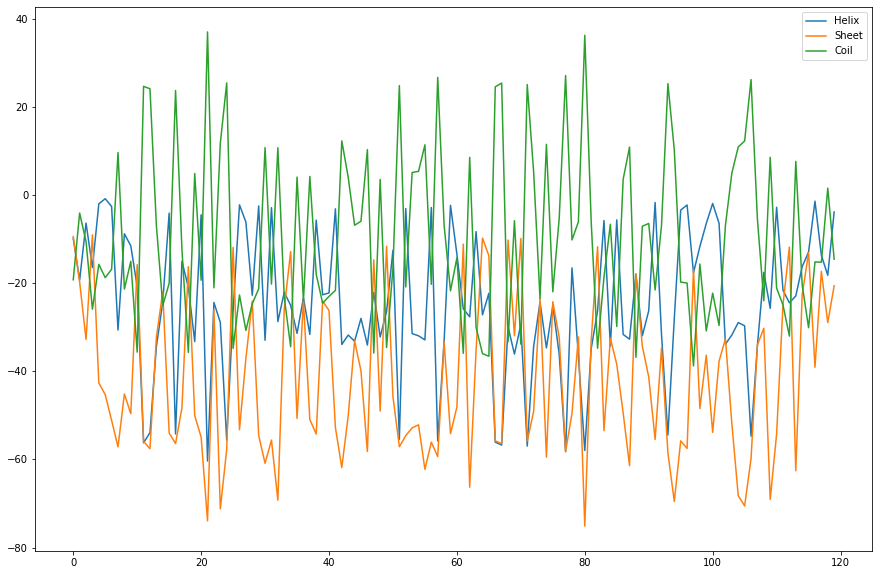

In [122]:
fig = plt.figure(figsize = (15,10))
plt.plot(ISS[0],label="Helix")
plt.plot(ISS[1],label="Sheet")
plt.plot(ISS[2],label="Coil")
plt.legend()

In [123]:
validEntries = SS_result>=0
SS_result = SS_result[validEntries]
testTrueSS = testTrueSS[validEntries]
            
Q3 = proteinQ3(SS_result, testTrueSS)
CVV = proteinCVV(SS_result, testTrueSS)
print(f"Q3={Q3}, CVV={CVV}")

ValueError: not enough values to unpack (expected 3, got 2)

In [125]:
testTrueSS

array([2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int8)

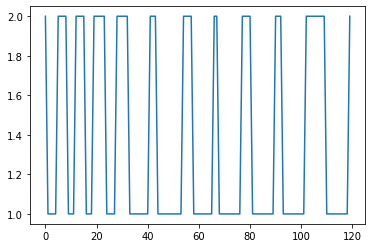

In [126]:
plt.plot(testTrueSS)

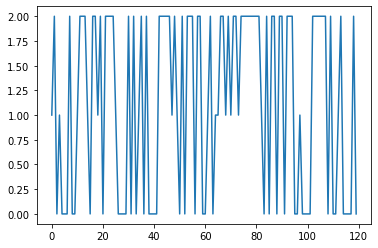

In [127]:
plt.plot(SS_result)

--------------

## Try and debug why prediciton is so bad

There are a few thing to look at if to see why it could maybe fail:

- Import is not correct. 
- Mistake in the methodolgy that we overlooked (try to find this out by taking it appiece)
- Frequencies are computed wrongly.
- Information stuff is computed wrongly.
- Mistake in the Q3 and CVV calculation?

### Check the import is correct:

Wanted behaviour:

- Convert aminoacids to numbers
- Convert SS to numbers
- Convert fault amino acids to -1
- Add -1's to for skipped entries.
    

In [11]:
# Look at protein: 1gpp_A
printSkips("1gpp","A")

Skipped exactly here:
[-1,1]
[54,67]
[183,410]
Given sequence positions:
[ -2  -1   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82
  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 410 411 412 413 414 415 416
 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434
 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452
 453]


In [15]:
residue1GPP = proteins.get_group(("1gpp","A"))["residue_name"].values
SS1GPP = proteins.get_group(("1gpp","A"))["SS"].values

In [16]:
residue1GPP

array([15,  0,  4, 13,  0, 11,  7, 16,  2, 19, 10, 12,  0,  3,  7, 15,  9,
        6,  4,  9,  6,  2,  9,  6, 19,  7,  2, 11, 19, 12,  7, 11,  3,  7,
        1, 14,  1,  6, 19,  9, 11, 10, 14,  1,  7, 15,  6, 16, 12, 18, 15,
       19, 19,  5, 11, 15, 12, 14,  6, 10, 10, 11, 13, 16,  4,  2,  0, 16,
        8,  6, 10, 19, 19,  1, 16, 14,  1, 15, 19,  1,  1, 10, 15,  1, 16,
        9, 11,  7, 19,  6, 18, 13,  6, 19,  9, 16, 13,  6, 12,  7,  5, 11,
       11,  0, 14,  3,  7,  1,  9, 19,  6, 10, 19, 11,  6, 19, 15, 11, 15,
       18, 14, 19, 15,  6,  7, 14,  6,  1,  0,  2,  6, 10, 19,  6, 15, 18,
        1, 11,  0, 15,  2, 11,  0, 18, 13,  6, 17, 16,  9,  6,  0,  1,  3,
       10, 15, 10, 10,  7, 15,  8, 19,  1, 11,  0, 16, 18,  5, 16, 18,  0,
       14,  9,  7,  0,  0, 13,  0,  1,  6,  4,  1,  7, 13, 18, 13,  6, 10,
        5,  6, 10, 11,  6,  3,  3, 18, 18,  7,  9, 16, 10, 15,  3,  3, 15,
        3,  8,  5, 13, 10, 10,  0,  2,  5, 19, 19, 19,  8], dtype=int8)

In [165]:
residue1GPPgood, SS1GPP = dsspDictionary["1gpp_A"]

In [33]:
for i, (res, ss) in enumerate(zip(residue1GPPgood,SS1GPP)):
    print(f"i={i} |{res}|{ss}|")

i=0 |15.0|2.0|
i=1 |0.0|1.0|
i=2 |-1.0|-1.0|
i=3 |4.0|1.0|
i=4 |13.0|1.0|
i=5 |0.0|2.0|
i=6 |11.0|2.0|
i=7 |7.0|2.0|
i=8 |16.0|2.0|
i=9 |2.0|1.0|
i=10 |19.0|1.0|
i=11 |10.0|1.0|
i=12 |12.0|2.0|
i=13 |0.0|2.0|
i=14 |3.0|2.0|
i=15 |7.0|2.0|
i=16 |15.0|2.0|
i=17 |9.0|1.0|
i=18 |6.0|1.0|
i=19 |4.0|1.0|
i=20 |9.0|2.0|
i=21 |6.0|2.0|
i=22 |2.0|2.0|
i=23 |9.0|2.0|
i=24 |6.0|2.0|
i=25 |19.0|2.0|
i=26 |7.0|2.0|
i=27 |2.0|2.0|
i=28 |11.0|1.0|
i=29 |19.0|1.0|
i=30 |12.0|1.0|
i=31 |7.0|2.0|
i=32 |11.0|2.0|
i=33 |3.0|2.0|
i=34 |7.0|2.0|
i=35 |1.0|2.0|
i=36 |14.0|1.0|
i=37 |1.0|1.0|
i=38 |6.0|1.0|
i=39 |19.0|1.0|
i=40 |9.0|1.0|
i=41 |11.0|1.0|
i=42 |10.0|2.0|
i=43 |14.0|2.0|
i=44 |1.0|1.0|
i=45 |7.0|1.0|
i=46 |15.0|1.0|
i=47 |6.0|1.0|
i=48 |16.0|1.0|
i=49 |12.0|1.0|
i=50 |18.0|1.0|
i=51 |15.0|1.0|
i=52 |19.0|1.0|
i=53 |19.0|1.0|
i=54 |5.0|1.0|
i=55 |11.0|2.0|
i=56 |15.0|2.0|
i=57 |-1.0|-1.0|
i=58 |-1.0|-1.0|
i=59 |-1.0|-1.0|
i=60 |-1.0|-1.0|
i=61 |-1.0|-1.0|
i=62 |-1.0|-1.0|
i=63 |-1.0|-1.0|
i=64 |-

So with loading the data is nothing wrong with. All is going like planned.

### Check the creation of the frequenty table.

In [166]:
table, countSS, countSSperR = freqTableOfProtein(residue1GPPgood, SS1GPP)
table[table ==0 ] = 0.00001
countSSperR[countSSperR==0] = 0.00001

It seems that the freq table is also correctly done... 

All the frequencies counts are correctly executed.

### Lets have a look at the predict SS 

In [52]:
otherSS = np.array([[1,2],[0,2],[0,1]])

In [167]:
logDiff = np.log(np.sum(countSS[otherSS],axis=-1)/countSS)
logDiffRj = np.log(np.sum(countSSperR[otherSS],axis=-2)/countSSperR) # -2 since -1 are the amino acids     

In [175]:
logDiff

array([ 2.40293307, -0.02765153,  0.36339389])

In [168]:
SS_result, ISS = predictSS(residue1GPPgood,table,logDiff,logDiffRj,SS1GPP)

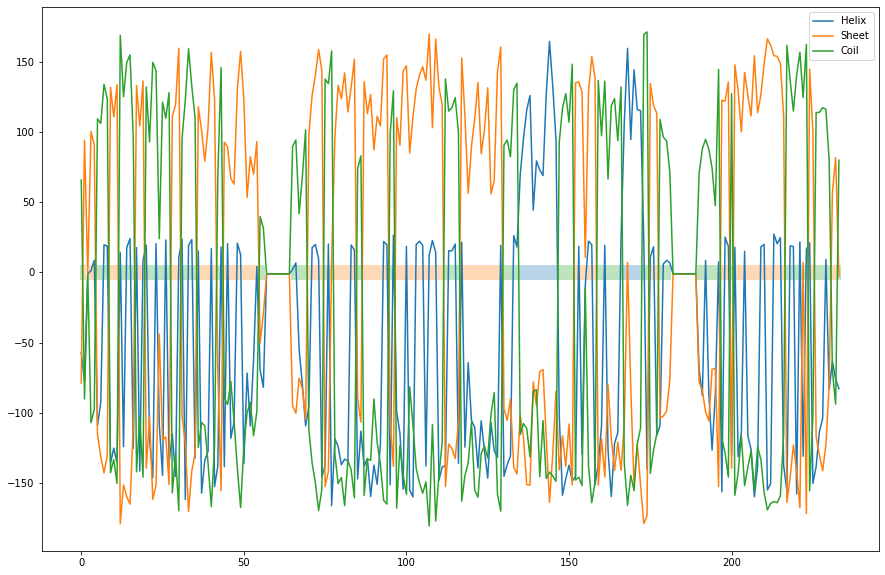

In [169]:
fig = plt.figure(figsize = (15,10))
plt.bar(np.where(SS1GPP==0)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(SS1GPP==1)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(SS1GPP==2)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.plot(ISS[0],label="Helix")
plt.plot(ISS[1],label="Sheet")
plt.plot(ISS[2],label="Coil")
plt.legend()

In [174]:
validEntries = SS_result>=0
SS_result = SS_result[validEntries]
SS1GPP = SS1GPP[validEntries]
            
Q3 = proteinQ3(SS_result, SS1GPP)
CVV = proteinCVV(SS_result, SS1GPP)
print(f"Q3={Q3}, CVV={CVV}")

Q3=[1. 1. 1.], CVV=[1. 1. 1.]


Ok so we found one mistake, we computed our log wrong. 
-> We see that we have now much more acceptable values and that it indeed seems to be doing in some regions doing it correctly. For example the helix region. And some coil regions. But somethis it also completly goes wrong... 

Let's further examine the predictSS, for no extra mistakes.

#### Table on itself.
Exploring 1ggp_A and the frequency table with itself.

When we just give it its own frequency table we see that it performance perfectly! So indeed we can assume that the method works of GOR3 works and it is just reality of the difficulty. 

It also seems that both the Q3 anc CVV are working correctly when it is just the frequency table. So again good points on that. 

--------

In [13]:
testProteinSeq, testTrueSS = dsspDictionary["2gpi_A"]
(table, count, countPerR) = freqTableOfProtein(testProteinSeq, testTrueSS)

In [14]:
ttotalFreqTable = np.zeros(shape=(3,17,20,20))
ttotalCountSS = np.zeros(3)
ttotalCountSSperR = np.zeros(shape=(3,20))
    
tproteinDictionary = createDataset(dataSet = "dssp", protFamily = None)
    
#First compute the full freqTable
for tkey, (tproteinSequence, ttrueSS) in tproteinDictionary.items():
    tfreqTableFromProt, tcountSSFromProt, tcountSSperRFromProt = freqTableOfProtein(tproteinSequence, ttrueSS)
    ttotalFreqTable += tfreqTableFromProt
    ttotalCountSS += tcountSSFromProt
    ttotalCountSSperR += tcountSSperRFromProt

In [15]:
subTable = ttotalFreqTable - table
subCount = ttotalCountSS - count
subCountPerR = ttotalCountSSperR - countPerR
otherSS = np.array([[1,2],[0,2],[0,1]])

subLog = np.log(np.sum(subCount[otherSS],axis=-1)/subCount)
subLogRj = np.log(np.sum(subCountPerR[otherSS],axis=-2)/subCountPerR) # -2 since -1 are the amino acids

subTable[subTable==0] = 0.0001

In [16]:
SS_result, ISS = predictSS(testProteinSeq,subTable,subLog,subLogRj,testTrueSS)

In [17]:
len(SS_result)

91

In [19]:
len(ISS[0])

91

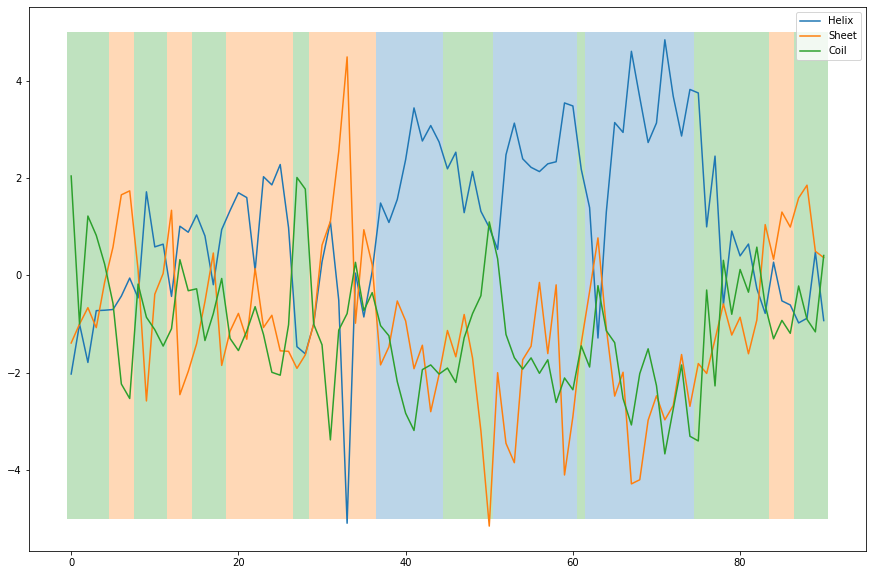

In [222]:
fig = plt.figure(figsize = (15,10))
plt.bar(np.where(testTrueSS==0)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==1)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.bar(np.where(testTrueSS==2)[0],height=10,width=1,alpha=0.3,bottom=-5)
plt.plot(ISS[0],label="Helix")
plt.plot(ISS[1],label="Sheet")
plt.plot(ISS[2],label="Coil")
plt.legend()

In [223]:
validEntries = SS_result>=0
OtherSS_result = SS_result[validEntries]
OthertestTrueSS = testTrueSS[validEntries]
            
Q3 = proteinQ3(OtherSS_result, OthertestTrueSS)
CVV = proteinCVV(OtherSS_result, OthertestTrueSS)
print(f"Q3={Q3}, CVV={CVV}")

Q3=[0.96774194 0.58333333 0.29411765], CVV=[0.49863239 0.49713862 0.40736645]


So these are the results we get for 1gpp_A. Now to be honnest it is also a difficult one since coil and sheet change often. 

We see that on other proteins we do also achieve a level of Q=50% somewhat. For example with protein 1w0n_A. The predictions are going actually some what really good. Only because we have this helix there does it sometimes go bad... but if you ignore the helix stuff. We see that the prediction is actually somewhat good.

-----
Lets now do the full analysis and see how it goes.

In [16]:
output = leaveOneOutAnalysis()

i=0/498
i=10/498
i=20/498
i=30/498
i=40/498
i=50/498
i=60/498
i=70/498
i=80/498
i=90/498
i=100/498
i=110/498
i=120/498
i=130/498
i=140/498
i=150/498
i=160/498
i=170/498
i=180/498
i=190/498
i=200/498
i=210/498
i=220/498
i=230/498
i=240/498
i=250/498
i=260/498
i=270/498
i=280/498
i=290/498
i=300/498
i=310/498
i=320/498
i=330/498
i=340/498
i=350/498
i=360/498
i=370/498
i=380/498
i=390/498
i=400/498
i=410/498
i=420/498
i=430/498
i=440/498
i=450/498
i=460/498
i=470/498
i=480/498
i=490/498


In [17]:
fullResultQ3, fullResultCVV = output

We have the following median results

In [21]:
Q3perSS = np.nanmean(fullResultQ3,axis=0)
Q3fullmean = np.nanmean(fullResultQ3)
CVVperSS = np.nanmean(fullResultCVV,axis=0)
CVVfullmean = np.nanmean(fullResultCVV)
print(f"Q3 results per SS = {Q3perSS}")
print(f"Q3 mean = {Q3fullmean}")
print(f"CVV results per SS = {CVVperSS}")
print(f"CVV mean  = {CVVfullmean}")

Q3 results per SS = [0.72811861 0.56024645 0.46954877]
Q3 mean = 0.5836373093455197
CVV results per SS = [0.3668805  0.3418456  0.36621004]
CVV mean  = 0.35924934579181883


You could argue that these results are even inflated. Because I remove nan values If I replace them with zeros we have:

In [22]:
fullResultQ3[np.isnan(fullResultQ3)] = 0
fullResultCVV[np.isnan(fullResultCVV)] = 0
Q3perSS = np.nanmean(fullResultQ3,axis=0)
Q3fullmean = np.nanmean(fullResultQ3)
CVVperSS = np.nanmean(fullResultCVV,axis=0)
CVVfullmean = np.nanmean(fullResultCVV)
print(f"Q3 results per SS = {Q3perSS}")
print(f"Q3 mean = {Q3fullmean}")
print(f"CVV results per SS = {CVVperSS}")
print(f"CVV mean  = {CVVfullmean}")

Q3 results per SS = [0.66963519 0.44999715 0.46954877]
Q3 mean = 0.5297270357915158
CVV results per SS = [0.33741219 0.27457478 0.36621004]
CVV mean  = 0.32606567128092795


Now you can argue if you need to add these as 0... I argue not, but it can certainly be argued that these nan should maybe also not be zero.